In [1]:
from plotnine.data import *
from plotnine import *
from matplotlib import ticker
import sys
sys.path.append('.')
sys.path.append('..')
sys.path.append('../compare')

import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import math
import numpy as np
import os
import mne
from scipy.io import loadmat
import pandas as pd
import seaborn.objects as so
from tqdm import tqdm
from matplotlib.pyplot import MultipleLocator
from matplotlib.gridspec import GridSpec
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

/Users/shinanlin/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/shinanlin/opt/anaconda3/lib/python3.8/site-packages/numba/core/types/__init__.py:108: FutureWarning: In the future `np.long` will be defined as the corresponding NumPy scalar.  (This may have returned Python scalars in past versions.


### default parapmeters

In [2]:
plt.rcParams['font.size'] = '5'
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams['svg.fonttype'] = 'none'

cm = 1/2.54
# 每次调用font dict
fontdict = dict(fontsize=7, family='Arial')

# red
red = '#A9373B'
blue = '#2369BD'
orange = '#CC8963'
green = '#009944'

In [1]:
capacity = []
add = '../results/sweep'
subs = os.listdir(add)

for sub in subs:
    subFolder = add+os.sep+sub
    if os.path.exists(subFolder+os.sep+'NaB_info.csv'):
        f = pd.read_csv(subFolder+os.sep+'info.csv')
        capacity.append(f)

capacity = pd.concat(capacity, ignore_index=True).drop_duplicates()
capacity = capacity[capacity.f>=1]
capacity.head()

NameError: name 'os' is not defined

In [45]:
import pickle
srate = 250
expName = 'sweep'

tau = np.arange(-0.5, 0.1+1/srate, 1/srate)
ts = np.arange(0, 1, 1/srate)

dir = '../data/datasets/%s.pickle' % expName

with open(dir, "rb") as fp:
    wholeset = pickle.load(fp)

sub = wholeset[-2]
chnNames = ['PZ', 'PO5', 'POZ', 'PO4', 'PO6', 'O1', 'OZ', 'O2', 'PO3']
chnINX = [sub['channel'].index(i) for i in chnNames]
X = sub['wn']['X'][:, chnINX]
y = sub['wn']['y']
S = sub['wn']['STI']

In [46]:
from modeling import EEG2Code
import sys
sys.path.append('../compare')
model = EEG2Code(srate=srate, winLEN=1, tmin=-0.5, tmax=0.1, S=(S,
                 np.unique(y)), estimator=0.98, padding=True, n_band=1, component=1)
model.fit(X, y)
sEst = model.predict(X)
xX = model.enhancer.transform(X)

## Fig a: Pics to construct a channel

### (a1) Spetral STI amd Resp

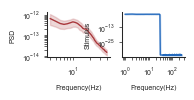

In [30]:
fig, (ax,ax1) = plt.subplots(1,2,figsize=(4.5*cm, 1.5*cm))

sns.set_theme(style='ticks', font='Arial', rc={"lines.linewidth": 1, 'font.size': 5, 'legend.fontsize': 5, 'legend.title_fontsize': 5, 'axes.labelsize': 5, 'xtick.labelsize': 5, 'ytick.labelsize': 5, })

sns.lineplot(data=capacity[(capacity.f>3)&(capacity.f<40)], x='f', y='X', ax=ax,color=red)
sns.lineplot(data=capacity, x='f', y='STI', ax=ax1,color=blue)

ax.set_ylabel('PSD')
ax1.set_ylabel('Stimulus')

for ax in fig.axes:
    
    ax.tick_params(labelsize=5, width=0.5, length=2, which='both')
    plt.setp(ax.spines.values(), linewidth=0.75)

    ax.set_xlabel('Frequency(Hz)')
    ax.set_yscale('log')
    ax.set_xscale('log')

sns.despine()
fig.savefig('../images/mainFig1/fig1a1.png',dpi=300,bbox_inches='tight')
fig.savefig('../images/mainFig1/fig1a1.svg',dpi=300,bbox_inches='tight')

### (a2) Temporal STI and Resp

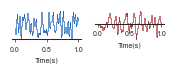

In [73]:
i = 4
s = model.STI[np.unique(y) == i][0]
r = model.enhanced[np.unique(y) == i][0]
sns.set_theme(style='ticks', font='Arial', rc={"lines.linewidth": 1, 'font.size': 5, 'legend.fontsize': 5,
              'legend.title_fontsize': 5, 'axes.labelsize': 5, 'xtick.labelsize': 5, 'ytick.labelsize': 5, })

fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(5*cm, 1*cm))

plt.subplots_adjust(hspace=0.5)
for spine in ['top', 'right', 'left']:
    ax1.spines[spine].set_visible(False)
    ax2.spines[spine].set_visible(False)
ax1.spines['bottom'].set_position(('data', 0))
ax2.spines['bottom'].set_position(('data', 0))


ax1.step(ts, s.T, color=blue, linestyle='solid', linewidth=0.5)
ax2.step(ts, r.T, color=red, linestyle='solid', linewidth=0.5)


for ax in (ax1,ax2):
    ax.tick_params(labelsize=5, width=0.5, length=2, which='both')
    plt.setp(ax.spines.values(), linewidth=0.75)
    ax.set_yticklabels([])
    ax.set_yticks([])

    ax.set_xlabel('Time(s)')

fig.savefig('../images/mainFig1/fig1a2.png', dpi=300, bbox_inches='tight')
fig.savefig('../images/mainFig1/fig1a2.svg', dpi=300, bbox_inches='tight')


### (a3) :TRF

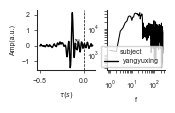

In [103]:
sns.set_theme(style='ticks', font='Arial', rc={"lines.linewidth": 1, 'font.size': 5, 'legend.fontsize': 5, 'legend.title_fontsize': 5, 'axes.labelsize': 5, 'xtick.labelsize': 5, 'ytick.labelsize': 5, })

fig,(ax1,ax2) = plt.subplots(1,2,figsize = (4.2*cm,2*cm))

ax1.plot(tau,model.trf.T,color='black')
ax1.axvline(0, linestyle='dashed', color='black', linewidth=0.5)

sns.lineplot(data=capacity[capacity.subject.isin(
    ['yangyuxing'])], x='f', y='Hf', palette=['black'], ax=ax2, hue='subject', linewidth=0.75)

for ax in (ax1,ax2):
    ax.tick_params(labelsize=5, width=0.5, length=2, which='both')
    plt.setp(ax.spines.values(), linewidth=0.75)

ax1.set_xlabel(r'$\tau(s)$')
ax1.set_ylabel('Amp(a.u.)')

ax2.set_yscale('log')
ax2.set_xscale('log')

sns.despine()
fig.savefig('../images/mainFig1/fig1a3.png',dpi=300,bbox_inches='tight')
fig.savefig('../images/mainFig1/fig1a3.svg',dpi=300,bbox_inches='tight')

## Fig b: Sig and noise

### (b1) : Spectral

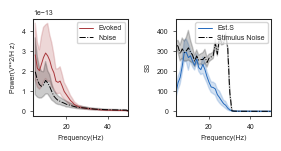

In [106]:

sns.set_theme(style='ticks', font='Arial', rc={"lines.linewidth": 0.7, 'font.size': 5, 'legend.fontsize': 5, 'legend.title_fontsize': 5, 'axes.labelsize': 5, 'xtick.labelsize': 5, 'ytick.labelsize': 5, })

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(3.9*2*cm,3.2*cm))

plt.subplots_adjust(wspace=0.5)

sns.lineplot(data=capacity[capacity.f > 4],
             x='f', y='sPower', ax=ax1, label='Evoked',color=red)

sns.lineplot(data=capacity[capacity.f>4],
             x='f', y='nPower', ax=ax1, label='Noise', color='black', linestyle='dashdot')

sns.lineplot(data=capacity,
             x='f', y='SS', ax=ax2, label='Est.S', color=blue)

sns.lineplot(data=capacity,
             x='f', y='NN', ax=ax2, label='Stimulus Noise', color='black', linestyle='dashdot')

# ax1.set_ylim(0, 1.5e-5)
# ax2.set_ylim(5e-2, 1.5e2)

for ax in fig.axes:

    ax.set_xlabel('Frequency(Hz)')
    ax1.set_ylabel(r'Power(V**2/H z)')

    ax.set_xlim(4, 50)
    ax.tick_params(labelsize=5, width=0.5, length=2, which='both')
    plt.setp(ax.spines.values(), linewidth=0.75)

    # ax.set_yscale('log')
    # ax.set_xscale('log')

fig.savefig('../images/mainFig1/fig1b1.png',dpi=300,bbox_inches='tight')
fig.savefig('../images//mainFig1/fig1b1.svg',dpi=300,bbox_inches='tight')

### (b2) Temporal

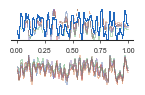

In [108]:
i = 7
s = model.STI[np.unique(y) == i]
s = np.repeat(s, repeats=6, axis=0)
es = sEst[y == i]
noise = s-es

sns.set_theme(style='ticks', font='Arial', rc={"lines.linewidth": 1, 'font.size': 5, 'legend.fontsize': 5,
              'legend.title_fontsize': 5, 'axes.labelsize': 5, 'xtick.labelsize': 5, 'ytick.labelsize': 5, })

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(4*cm, 2.5*cm))

plt.subplots_adjust(hspace=0.5)
for spine in ['top', 'right', 'left']:
    ax1.spines[spine].set_visible(False)
    ax2.spines[spine].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax1.spines['bottom'].set_position(('data', 0))

ax1.step(ts, es.T, alpha=0.6, linewidth=0.5)
ax1.step(ts, s.T, color='white', linestyle='solid', linewidth=1.2)
ax1.step(ts, s.T, color=blue, linestyle='solid', linewidth=0.5)

ax2.step(ts, noise.T, alpha=0.6, linewidth=0.5)

for ax in (ax1, ax2):
    ax.tick_params(labelsize=5, width=0.5, length=2, which='both')
    plt.setp(ax.spines.values(), linewidth=0.75)
    ax.set_yticklabels([])
    ax.set_yticks([])

ax1.set_ylim(0, 1)
ax2.set_ylim(-.6, .6)
ax1.set_xlabel('Time(s)')

ax2.set_xticklabels([])
ax2.set_xticks([])

fig.savefig('../images/mainFig1/fig1b21.png', dpi=300, bbox_inches='tight')
fig.savefig('../images/mainFig1/fig1b21.svg', dpi=300, bbox_inches='tight')

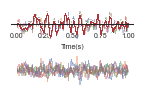

In [109]:
i = 4
s = model.enhanced[np.unique(y) == i][0]
s = np.repeat(s, repeats=6, axis=0)
x = np.squeeze(xX[y == i])
noise = x-s

sns.set_theme(style='ticks', font='Arial', rc={"lines.linewidth": 1, 'font.size': 5, 'legend.fontsize': 5,
              'legend.title_fontsize': 5, 'axes.labelsize': 5, 'xtick.labelsize': 5, 'ytick.labelsize': 5, })

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(4*cm, 2.5*cm))

plt.subplots_adjust(hspace=0.5)
for spine in ['top', 'right', 'left']:
    ax1.spines[spine].set_visible(False)
    ax2.spines[spine].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax1.spines['bottom'].set_position(('data', 0))

ax1.step(ts, x.T, alpha=0.6, linewidth=0.5)
ax1.step(ts, s.T, color='white', linestyle='solid', linewidth=1.2)
ax1.step(ts, s.T, color=red, linestyle='solid', linewidth=0.5)

ax2.step(ts, noise.T, alpha=0.6, linewidth=0.5)

for ax in (ax1, ax2):
    ax.tick_params(labelsize=5, width=0.5, length=2, which='both')
    plt.setp(ax.spines.values(), linewidth=0.75)
    ax.set_yticklabels([])
    ax.set_yticks([])

ax1.set_xlabel('Time(s)')

ax2.set_xticklabels([])
ax2.set_xticks([])

fig.savefig('../images/mainFig1/fig1b22.png', dpi=300, bbox_inches='tight')
fig.savefig('../images/mainFig1/fig1b22.svg', dpi=300, bbox_inches='tight')


## Fig c: SNR

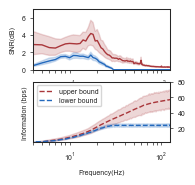

In [129]:
sns.set_theme(style='ticks', font='Arial', rc={"lines.linewidth": 1, 'font.size': 5, 'legend.fontsize': 5, 'legend.title_fontsize': 5, 'axes.labelsize': 5, 'xtick.labelsize': 5, 'ytick.labelsize': 5, })

fig,(ax1,ax2) = plt.subplots(2,1,figsize=(4.5*cm,4.4*cm))

plt.subplots_adjust(wspace=0.5)

sns.lineplot(data=capacity, x='f', y='ubSNR', ax=ax1,color=red)

sns.lineplot(data=capacity, x='f', y='lbSNR', ax=ax1, color=blue)

sns.lineplot(data=capacity, x='f', y='ubrate', ax=ax2, label='upper bound', color=red, linestyle='dashed')

sns.lineplot(data=capacity, x='f', y='lbrate', ax=ax2,label='lower bound',color=blue,linestyle='dashed')

ax2.yaxis.tick_right()

for ax in fig.axes:

    ax.set_xlim(4, 125)
    ax.tick_params(labelsize=5, width=0.5, length=2, which='both')
    plt.setp(ax.spines.values(), linewidth=0.75)
    ax.set_xscale('log')
    ax.set_xlabel('Frequency(Hz)')


ax1.set_ylabel('SNR(dB)')
ax2.set_ylabel('Information (bps)')

ax2.set_ylim(2, 80)
ax1.set_ylim(0, 7)


fig.savefig('../images/mainFig1/fig1c.png',dpi=300,bbox_inches='tight')
fig.savefig('../images/mainFig1/fig1c.svg',dpi=300,bbox_inches='tight')

## Fig D: Linearity

In [35]:
LN = []
add = '../results/sweep'
subs = os.listdir(add)

for sub in subs:
    subFolder = add+os.sep+sub
    if os.path.exists(subFolder+os.sep+'LN.csv'):
        f = pd.read_csv(subFolder+os.sep+'LN.csv')
        LN.append(f)

LN = pd.concat(LN, ignore_index=True, axis=0)

aveLN = LN.groupby(by=['subject', 'mode'], as_index=False).mean()
aveLN.head()
aveLN.tail()

/var/folders/z8/m0rtcw1d0g37chf76qrvr9pw0000gn/T/ipykernel_7406/1100692315.py:13: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.


,subject,mode,Unnamed: 0,accuracy,winLEN,ITR,cv,seed,score
25,yaofeifan,linear,2999.5,0.952379,0.86,212.397896,2.5,499.5,0.900000
26,yaofeifan,nonlinear,8999.5,0.838325,0.86,170.784176,2.5,499.5,0.692708
27,zhangtiantian,full,14999.5,0.994654,0.86,232.148406,2.5,499.5,0.994792
28,zhangtiantian,linear,2999.5,0.820471,0.86,163.790404,2.5,499.5,0.683333
29,zhangtiantian,nonlinear,8999.5,0.804767,0.86,158.581990,2.5,499.5,0.652083


### (d1) classification

/Users/shinanlin/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:3544: UserWarning: 10.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.


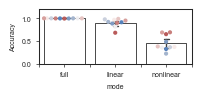

In [98]:
sns.set_theme(style='ticks', font='Arial', rc={"lines.linewidth": 1, 'font.size': 5, 'legend.fontsize': 5,
              'legend.title_fontsize': 5, 'axes.labelsize': 5, 'xtick.labelsize': 5, 'ytick.labelsize': 5, })

f,ax = plt.subplots(figsize=(5*cm,1.8*cm))


sns.barplot(data=aveLN, x='mode', y='score',
            linewidth=0.5, errwidth=1, capsize=0.1, edgecolor='black', facecolor=(0, 0, 0, 0),)
sns.swarmplot(data=aveLN, x='mode', y='score', hue='subject',
              legend=False, size=3, palette='vlag')

ax.tick_params(labelsize=5, width=0.5, length=2, which='both',)
plt.setp(ax.spines.values(), linewidth=0.75)

ax.set_ylim(0,1.2)
ax.xaxis.set_major_locator(ticker.MultipleLocator(0.5))
ax.set_ylabel('')
ax.set_ylabel('Accuracy')

plt.savefig('../images/mainFig1/fig1d1.png',dpi=400,bbox_inches='tight')
plt.savefig('../images/mainFig1/fig1d1.svg',dpi=400,bbox_inches='tight')

### (d2) temporal waveform

In [47]:
from sklearn.model_selection import LeaveOneOut
from compare.spatialFilters import *
sub = wholeset[-2]
tag='wn'
X = sub[tag]['X']
y = sub[tag]['y']
S = sub[tag]['STI']
_class = np.unique(y)

X = np.stack([X[y == i] for i in np.unique(y)])
y = np.stack([y[y == i] for i in np.unique(y)])

# classification
X = np.transpose(X, axes=(1, 0, -2, -1))
y = np.transpose(y, axes=(-1, 0))

loo = LeaveOneOut()
loo.get_n_splits(X)

for cv, (train_index, test_index) in enumerate(loo.split(X, y)):

    X_train, X_test = np.concatenate(
        X[train_index]), np.concatenate(X[test_index])
    y_train, y_test = np.concatenate(
        y[train_index]), np.concatenate(y[test_index])

    model = LN(S=(S,_class),n_band=1,winLEN=0.86,lag=.14,mode='linear',montage=160)
    model.fit(X_train,y_train)
    acc = model.score(X_test,y_test)
    break

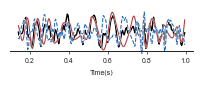

In [54]:
t = np.arange(0.14,1,1/srate)
sns.set_theme(style='ticks', font='Arial', rc={"lines.linewidth": 1, 'font.size': 5, 'legend.fontsize': 5,
              'legend.title_fontsize': 5, 'axes.labelsize': 5, 'xtick.labelsize': 5, 'ytick.labelsize': 5, })
f,ax = plt.subplots(figsize=(6.0*cm,1.5*cm))

classINX = 11

ax.plot(t,model.full[classINX].T,color='black',linewidth=1)

ax.plot(t,model.linear[classINX].T,color='white',linewidth=1)
ax.plot(t,model.linear[classINX].T,color=red,linewidth=0.75)

ax.plot(t, model.nonlinear[classINX].T, color='white',linestyle='solid',linewidth=1)
ax.plot(t, model.nonlinear[classINX].T, color=blue,linestyle='dashed',linewidth=0.75)


for spine in ['top', 'right', 'left']:
    ax.spines[spine].set_visible(False)
ax.spines['bottom'].set_position(('data', -0.5))

ax.tick_params(labelsize=5, width=0.5, length=2, which='both')
plt.setp(ax.spines.values(), linewidth=0.75)

ax.set_xlabel('Time(s)')

ax.set_yticklabels([])
ax.set_yticks([])

plt.savefig('../images/mainFig1/fig1d2.png',dpi=400,bbox_inches='tight')
plt.savefig('../images/mainFig1/fig1d2.svg',dpi=400,bbox_inches='tight')

### (d3) Transfer Matrix

In [55]:
LNcM = []
add = '../results/sweep'
subs = os.listdir(add)

for sub in subs:
    subFolder = add+os.sep+sub
    if os.path.exists(subFolder+os.sep+'LNcM.csv'):
        f = pd.read_csv(subFolder+os.sep+'LNcM.csv')
        LNcM.append(f)

LNcM = pd.concat(LNcM, ignore_index=True, axis=0)
LNcM = LNcM[LNcM.subject == 'fanzixiao']
LNcM.tail()


,Unnamed: 0,j,i,rho,subject,method,mode,winLEN,cv
2764795,460795,156,160,-0.441458,fanzixiao,wn,full,0.86,5
2764796,460796,157,160,0.046900,fanzixiao,wn,full,0.86,5
2764797,460797,158,160,-0.436399,fanzixiao,wn,full,0.86,5
2764798,460798,159,160,-0.171659,fanzixiao,wn,full,0.86,5
2764799,460799,160,160,2.180855,fanzixiao,wn,full,0.86,5


In [56]:
LNcM_linear = LNcM[LNcM['mode']=='linear'].pivot_table(index='i',columns='j',values='rho')
LNcM_nonlinear = LNcM[LNcM['mode']=='nonlinear'].pivot_table(index='i',columns='j',values='rho')
LNcM_full = LNcM[LNcM['mode']=='full'].pivot_table(index='i',columns='j',values='rho')

In [65]:
vmin = np.min(np.concatenate([LNcM_full,  LNcM_linear, LNcM_nonlinear]))
vmax = np.max(np.concatenate([LNcM_linear]))


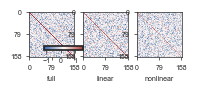

In [100]:
sns.set_theme(style='ticks', font='Arial', rc={"lines.linewidth": 1, 'font.size': 5, 'legend.fontsize': 5,
              'legend.title_fontsize': 5, 'axes.labelsize': 5, 'xtick.labelsize': 5, 'ytick.labelsize': 5, })

f, axes = plt.subplots(1, 3, figsize=(5*cm, 2*cm))

cax = plt.axes([0.2, 0.3, 0.2, 0.05])

a = axes[0].imshow(LNcM_full.to_numpy(), cmap='vlag',
               interpolation='none', vmin=vmin, vmax=vmax)
axes[1].imshow(LNcM_linear.to_numpy(), cmap='vlag',
               interpolation='none', vmin=vmin, vmax=vmax)
axes[2].imshow(LNcM_nonlinear.to_numpy(), cmap='vlag',
               interpolation='none', vmin=vmin, vmax=vmax)


axes[0].set_xlabel('full')
axes[1].set_xlabel('linear')
axes[2].set_xlabel('nonlinear')

for ax in f.axes:
    ax.tick_params(labelsize=5, width=0.5, length=2, which='both')
    plt.setp(ax.spines.values(), linewidth=0.5)

for ax in axes:
    ax.xaxis.set_major_locator(ticker.IndexLocator(base=79, offset=0.5))
    ax.yaxis.set_major_locator(ticker.IndexLocator(base=79, offset=0.5))

plt.colorbar(a, cax=cax,orientation='horizontal')

plt.savefig('../images/mainFig1/fig1d3.png', dpi=400, bbox_inches='tight')
plt.savefig('../images/mainFig1/fig1d3.svg', dpi=400, bbox_inches='tight')

## Fig E: Broadband and Narrowband SNR

In [11]:
compare = []

exps = ['NBB']

for exp in exps:

    add = '../results/%s'%exp
    subs = os.listdir(add)

    for sub in subs:
        subFolder = add+os.sep+sub
        if os.path.exists(subFolder+os.sep+'NaB_info.csv'):
            f = pd.read_csv(subFolder+os.sep+'NaB_info.csv')
            compare.append(f)

compare = pd.concat(compare, ignore_index=True, axis=0)
compare.tail()

,Unnamed: 0,f,ubSNR,ubrate,sPower,nPower,X,exp,subject,ubINFO,tag
2995,495,122.5,0.782376,54.624411,2.345167e-07,3.203228e-07,3.828071e-07,NBB,miaoyining,55.365195,SSVEP
2996,496,123.0,0.787246,55.046372,2.143930e-07,2.911435e-07,3.485164e-07,NBB,miaoyining,55.365195,SSVEP
2997,497,123.5,0.792069,54.996051,2.017109e-07,2.725018e-07,3.266512e-07,NBB,miaoyining,55.365195,SSVEP
2998,498,124.0,0.796001,55.415780,1.938662e-07,2.608675e-07,3.130214e-07,NBB,miaoyining,55.365195,SSVEP
2999,499,124.5,0.798542,55.365195,1.895657e-07,2.544546e-07,3.055140e-07,NBB,miaoyining,55.365195,SSVEP


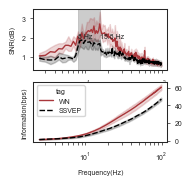

In [26]:
sns.set_theme(style='ticks', font='Arial', rc={"lines.linewidth": 1, 'font.size': 5, 'legend.fontsize': 5,'legend.title_fontsize': 5, 'axes.labelsize': 5, 'xtick.labelsize': 5, 'ytick.labelsize': 5, })

fig, (ax1,ax2) = plt.subplots(2, 1, figsize=(4.4*cm, 4.4*cm))

plt.subplots_adjust(wspace=0.3)

ax1.axvspan(xmin=8,xmax=15.8,facecolor='black',alpha=0.2,lw=0.5,edgecolor='black')

sns.lineplot(data=compare[(compare.f > 2) & (compare.f < 100)],
             x='f', y='ubSNR', hue='tag', ax=ax1, legend=False, style='tag',palette=[red,'black'])

sns.lineplot(data=compare[(compare.f>2)&(compare.f<100)],
             x='f', y='ubrate', hue='tag', ax=ax2, style='tag', legend=True, palette=[red, 'black'])

ax2.yaxis.tick_right()


ax1.text(x=8, y=2, s='8 Hz')
ax1.text(x=15.8,y=2,s='15.8 Hz')

ax1.set_ylabel('SNR(dB)')
ax2.set_ylabel('Information(bps)')
ax2.set_xlabel('Frequency(Hz)')

for ax in (ax1, ax2):
    ax.tick_params(labelsize=5, width=0.5, length=2, which='both')
    plt.setp(ax.spines.values(), linewidth=0.75)
    ax.set_xscale('log')

plt.savefig('../images/mainFig1/fig1e.png',dpi=400,bbox_inches='tight')
plt.savefig('../images/mainFig1/fig1e.svg',dpi=400,bbox_inches='tight')

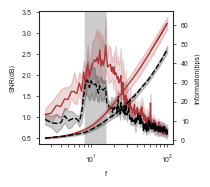

In [16]:
sns.set_theme(style='ticks', font='Arial', rc={"lines.linewidth": 1, 'font.size': 5, 'legend.fontsize': 5,'legend.title_fontsize': 5, 'axes.labelsize': 5, 'xtick.labelsize': 5, 'ytick.labelsize': 5, })

fig, (ax1) = plt.subplots(1, 1, figsize=(4.4*cm, 4.4*cm))

ax2 = ax1.twinx()
plt.subplots_adjust(wspace=0.3)

ax1.axvspan(xmin=8,xmax=15.8,facecolor='black',alpha=0.2)

sns.lineplot(data=compare[(compare.f > 2) & (compare.f < 100)],
             x='f', y='ubSNR', hue='tag', ax=ax1, legend=False, style='tag',palette=[red,'black'])

sns.lineplot(data=compare[(compare.f>2)&(compare.f<100)],
             x='f', y='ubrate', hue='tag', ax=ax2, style='tag', legend=False, palette=[red, 'black'])

ax2.yaxis.tick_right()

ax1.set_ylabel('SNR(dB)')
ax2.set_ylabel('Information(bps)')
ax2.set_xlabel('Frequency(Hz)')

for ax in (ax1, ax2):
    ax.tick_params(labelsize=5, width=0.5, length=2, which='both')
    plt.setp(ax.spines.values(), linewidth=0.75)
    ax.set_xscale('log')

plt.savefig('../images/mainFig1/fig1e.png',dpi=400,bbox_inches='tight')
plt.savefig('../images/mainFig1/fig1e.svg',dpi=400,bbox_inches='tight')